In [198]:
from field_of_view import FieldOfView
from clusters import ClusterParam, Cluster
from plot_helpers import moving_average

import numpy as np
from matplotlib import pyplot as plt

In [199]:
nm_per_pixel = 21.34
time_per_frame = 0.1
Tau_D_GluA1 = 150.32
Tau_D_GluA2 = 97
background_threshold = 200
homer_path = '../Examples/A1_aHomer_corrected.csv'
life_act_path = '../Examples/A1_Composite.tif'
deepd3_path = 'DeepD3_32F.h5'
deepd3_pred_tresh = 0.2
points_data = [['GluA1', r'../Examples/A1_GluA1_corrected.csv', 'white', time_per_frame, Tau_D_GluA1],
               ['GluA2', r'../Examples/A1_GluA2_corrected.csv', 'cyan', time_per_frame, Tau_D_GluA2]]
# Params = [ClusterParam(35, 10, 500, 50 , 'GluA2')]
Params = []


In [200]:
FOV = FieldOfView(homer_centers=homer_path, 
                  life_act=life_act_path, 
                  nm_per_pixel=nm_per_pixel,
                  points=points_data, 
                  Params=Params, 
                  threshold=background_threshold,
                  deepd3_model_path=deepd3_path,
                  deepd3_pred_thresh=deepd3_pred_tresh,
                  to_plot=False,
                  filter_spines=False)

Loading Life Act...
Setting up Thresholding...
1/1 [==============================] - 0s 364ms/step
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Loading Homer Centers...
Loading GluA1...
Loading GluA2...
Assigning Points to Spines...


clusters.py (223): Mean of empty slice.
_methods.py (184): invalid value encountered in divide


In [11]:
GluA1 = FOV.Points[0]
GluA2 = FOV.Points[1]
LifeAct = FOV.life_act

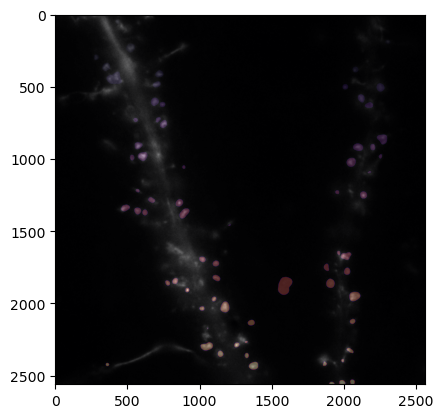

In [201]:
plt.figure()
plt.imshow(LifeAct, cmap='gray')

plt.imshow(FOV.spinemap, cmap='magma', alpha=0.3)
# plt.scatter(GluA1[:, 0], GluA1[:, 1], s=0.05, c='white')

In [204]:
from points import SubPoints
from scipy.spatial import KDTree
from scipy.cluster.vq import kmeans
from sklearn.linear_model import LinearRegression

def points_in_area(points, xlim, ylim):
    x_mask = (points[:, 0] >= xlim[0]) & (points[:, 0] <= xlim[1])
    y_mask = (points[:, 1] >= ylim[1]) & (points[:, 1] <= ylim[0])
    indices = np.where(x_mask & y_mask)[0]
    return Cluster(points, indices, label=points.label)

def filter_by_nth_neighbor_distance(points, n, max_distance):
    kdtree = KDTree(points)
    distances = np.array(kdtree.query(points, k=n, workers=-1)[0][:, -1])
    indices = np.where(distances < max_distance)
    return Cluster(points, indices, label=points.label), distances[indices]

def get_clusters_kmeans(points, to_plot=False):
    # Range of k values
    k_values = np.array(range(1, 31))
    sse = []

    # Calculating SSE for each k
    for k in k_values:
        centroids, distortion = kmeans(points, k)
        sse.append(distortion)

    differences = []
    for i in range(len(sse) - 1):
        differences.append(sse[i+1] - sse[i])
    if to_plot:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(k_values, sse, 'bx-')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.title("Elbow Method For Optimal k")

        plt.subplot(1, 2, 2)
        plt.plot(k_values[:-1], differences, 'go-')
        plt.xlabel('k')
        plt.ylabel('Different Between Points')
        
        plt.tight_layout()
        plt.show()


42.53266757451959


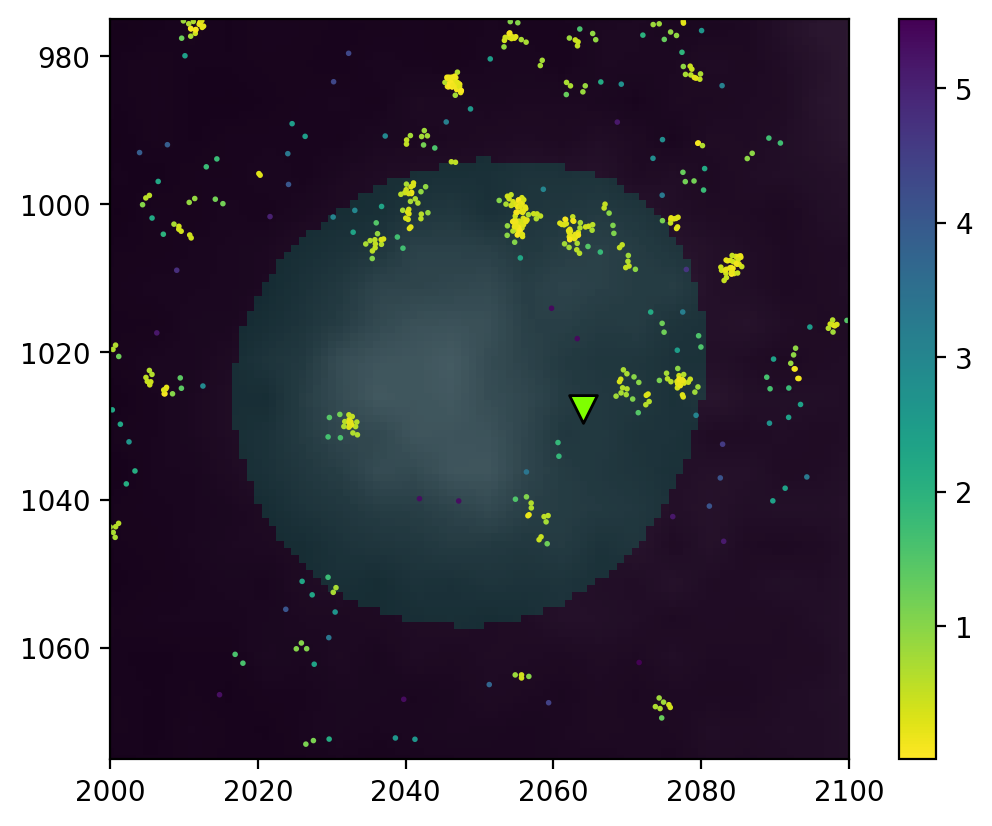

No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


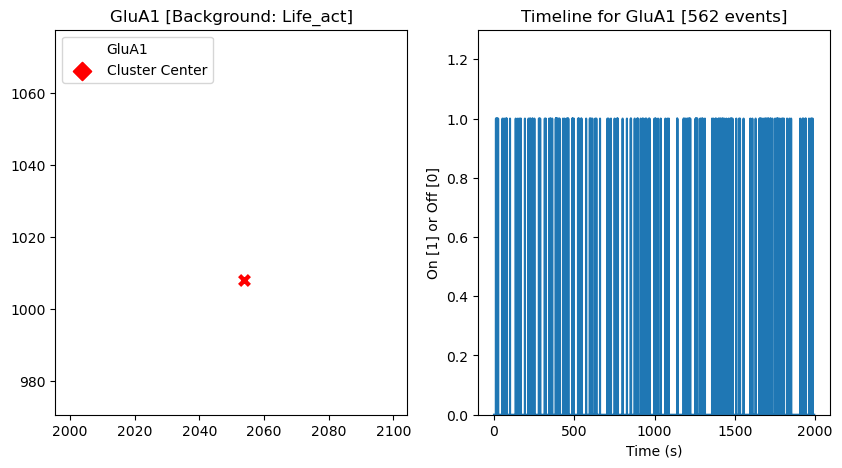

In [213]:
xlim = (2000, 2100)
ylim = (1075, 975)
n=2
max_distance = 120/nm_per_pixel

# MMD Visualization
points = points_in_area(GluA1, xlim, ylim)
kdtree = KDTree(points)
distances = np.array(kdtree.query(points, k=n, workers=-1)[0][:, -1])

points, distances = filter_by_nth_neighbor_distance(points, n, max_distance)
get_clusters_kmeans(points)
# points, distances = filter_by_nth_neighbor_distance(points, n, 7.5)


print(points.Tau_D/points.average_dark_time)
plt.figure(dpi=200)
plt.imshow(LifeAct, cmap='gray')
plt.imshow(FOV.spinemap, alpha=0.3)
plt.xlim(*xlim)
plt.ylim(*ylim)
FOV.homer_centers.add_to_plot()
plt.scatter(points[:, 0], points[:, 1], c=distances, s=1, cmap='viridis_r')
plt.colorbar()
plt.show()
points.plot()
